In [26]:
# import packages
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns  

In [27]:
# Import data
path = Path('/Users/thuymle/Dropbox/SIEPR Projects/Inflation and Election Swings')
input = path / 'input'
output = path / 'output'
data = path / 'data'
election_data = data / 'election_data'

inflation_file = input / 'bls_panel_data_division.csv'
df_inflation = pd.read_csv(inflation_file)

election_file = election_data / 'clean' / 'trump_2020_2024.csv'
df_election = pd.read_csv(election_file)

crosswalk_file = output / 'state_division_crosswalk.csv'
df_crosswalk = pd.read_csv(crosswalk_file)


In [28]:
# Reshape and clean
df_inflation['month'] = df_inflation.apply(
    lambda row: f"{row['year']}-{row['period'][1:]}", axis=1

) 
df_inflation = df_inflation.drop(columns = ['year', 'period'])

inflation_reshaped = df_inflation.pivot_table(
    index=['category', 'divisions', 'series_id'], 
    columns=['month'],                 
    values='price_index'
)

# Reset the index to flatten the resulting DataFrame
inflation_reshaped.reset_index(inplace=True)
inflation_reshaped

month,category,divisions,series_id,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,...,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10
0,apparel,East North Central,CUUR0230SAA,101.611,104.533,103.791,101.884,100.674,99.985,99.602,...,101.223,104.589,104.478,104.339,105.165,102.796,102.402,103.653,108.287,108.166
1,apparel,East South Central,CUUR0360SAA,104.829,106.287,105.298,107.238,107.289,104.686,101.579,...,111.377,117.718,117.828,118.975,120.231,119.269,115.748,116.503,120.214,121.514
2,apparel,Middle Atlantic,CUUR0120SAA,100.120,104.280,103.649,101.805,102.109,102.342,99.761,...,105.280,108.268,111.621,110.481,110.029,109.515,106.191,109.145,112.246,109.193
3,apparel,Mountain,CUUR0480SAA,99.405,100.036,101.375,100.689,100.292,98.193,96.091,...,109.161,110.833,112.421,111.822,111.666,111.348,109.543,110.712,112.306,110.720
4,apparel,New England,CUUR0110SAA,107.356,105.587,109.237,110.644,105.735,108.000,107.946,...,104.365,107.536,109.262,106.593,104.553,104.949,103.255,106.177,109.711,108.092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,transportation,New England,CUUR0110SAT,99.130,99.366,100.906,102.920,104.201,103.390,103.342,...,121.943,123.447,125.384,127.736,129.080,127.664,127.022,126.366,125.944,125.107
68,transportation,Pacific,CUUR0490SAT,103.282,103.392,104.230,108.043,109.627,108.222,107.110,...,130.657,132.512,137.055,140.451,140.013,137.741,136.076,134.505,135.428,135.378
69,transportation,South Atlantic,CUUR0350SAT,99.527,100.390,103.133,105.317,104.912,103.545,104.580,...,129.313,132.019,134.116,135.500,135.815,134.211,134.496,133.307,131.644,132.046
70,transportation,West North Central,CUUR0240SAT,97.357,99.182,102.708,105.374,104.811,103.908,103.840,...,127.516,129.481,133.925,134.660,134.224,133.718,134.429,133.743,132.574,132.287


In [29]:
# Inflation calculate
inflation_reshaped['cumulative_inflation'] = inflation_reshaped['2024-10'] - inflation_reshaped['2021-01']

In [ ]:
# Find rows where '2024 swing' is missing
missing_swing_states = df_election.loc[df_election['2020-2024 swing'].isna(), 'state']

# Convert to a unique list if needed
unique_states = missing_swing_states.unique()
print(unique_states)


['alaska' 'illinois' 'maryland' 'minnesota' 'missouri' 'nevada'
 'new mexico' 'rhode island' 'virginia']


In [31]:
# Election
# Note that Massachusetts is missing in election data
df_election['state'] = df_election['state'].str.capitalize()
election_merged = pd.merge(df_election, df_crosswalk, on = 'state')

# collapse to divisions
election_division = election_merged.groupby('divisions', as_index = False).sum()
election_division = election_division.drop(columns = ['state', 'county_name', 'trump %, 2020', 'trump %, 2024', '2020-2024 swing'])
election_division['trump_share_2020'] = election_division['trump votecount, 2020'] / election_division['totalvotes, 2020'] * 100
election_division['trump_share_2024'] = election_division['trump votecount, 2024'] / election_division['totalvotes, 2024'] * 100
election_division['trump_vote_change'] = election_division['trump_share_2024'] - election_division['trump_share_2020']
election_division = election_division[['divisions', 'trump_vote_change']]

# merge with inflation data
election_inflation = pd.merge(election_division, inflation_reshaped, on="divisions")
election_inflation = election_inflation[['divisions', 'category', 'series_id', 'trump_vote_change', 'cumulative_inflation']]

file = output / "inflation_vote_swing.csv"
election_inflation.to_csv(file, index=False)

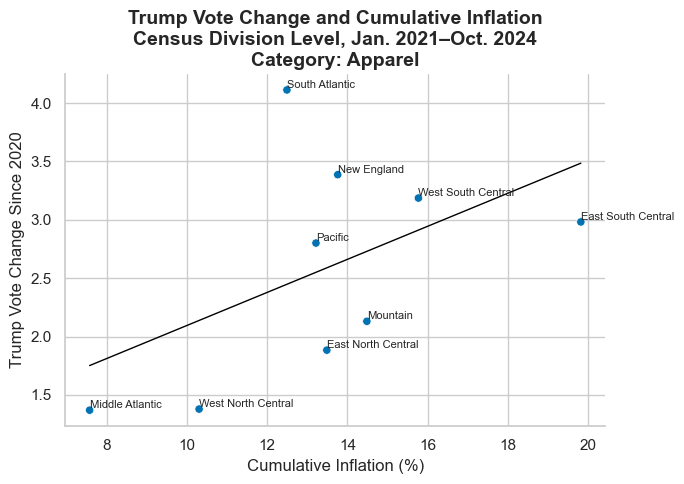

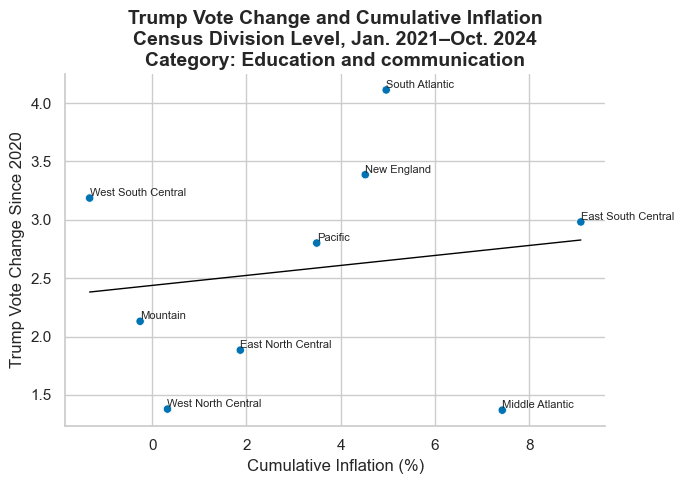

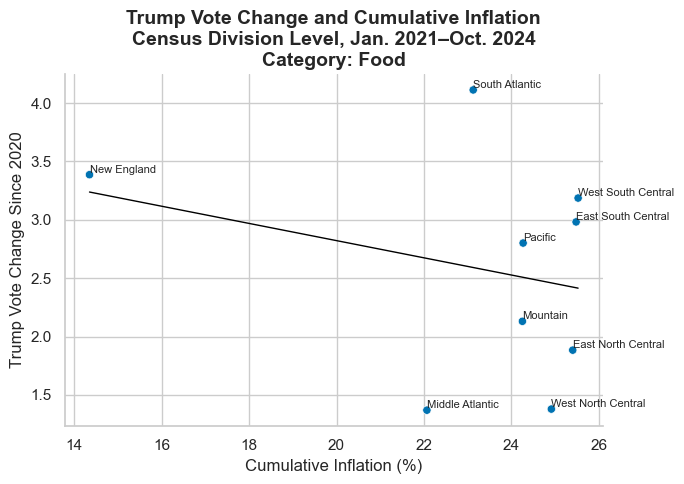

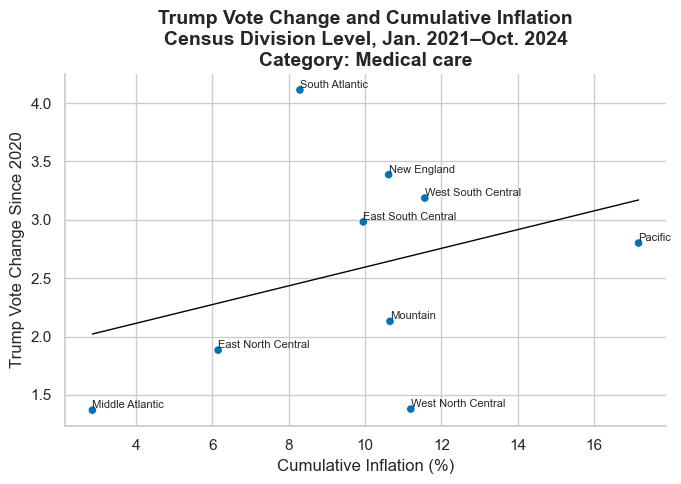

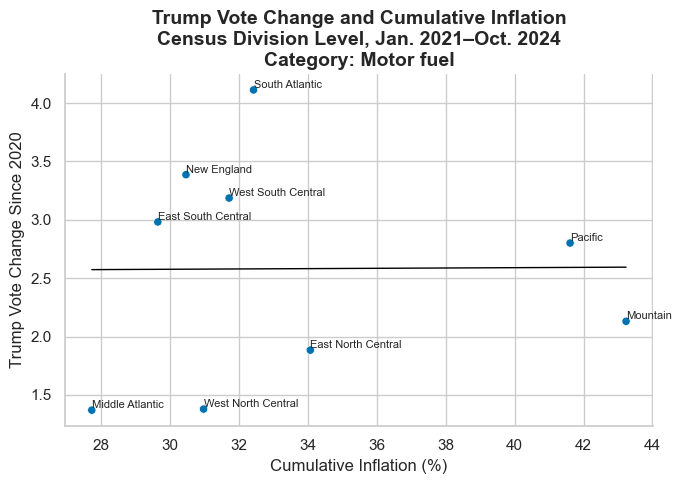

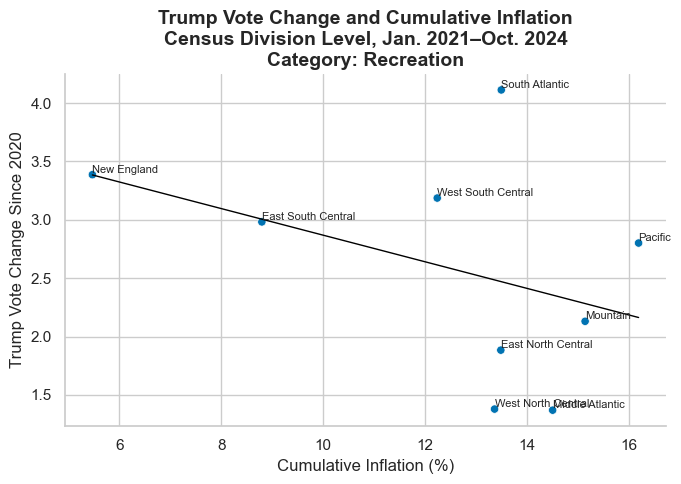

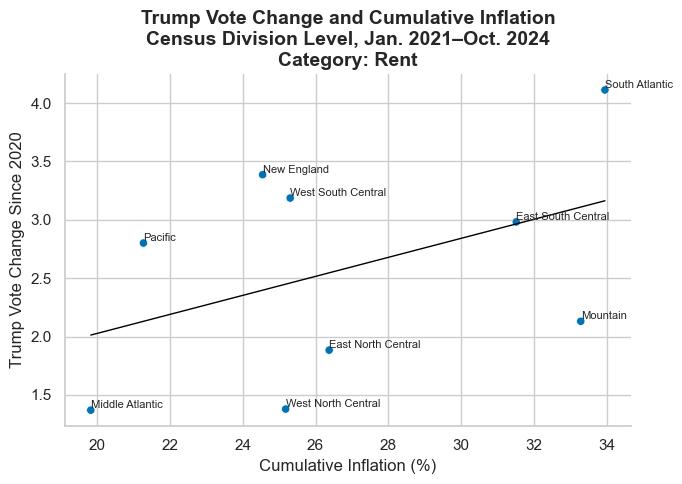

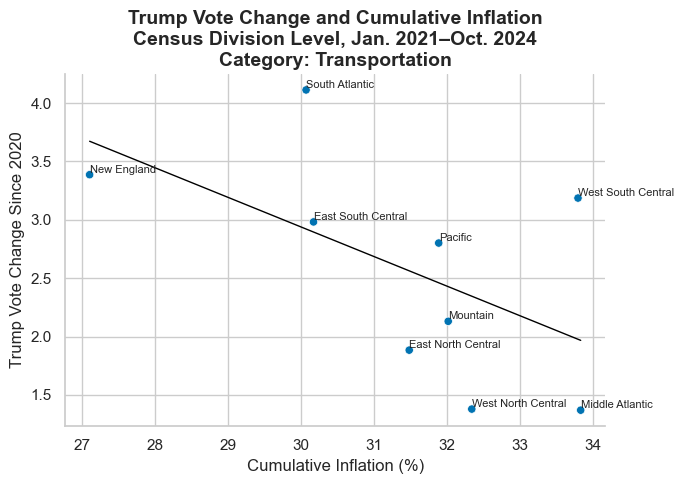

In [32]:
# Capitalize categories
election_inflation['category'] = election_inflation['category'].str.capitalize()
categories = election_inflation['category'].unique()

sns.set(style="whitegrid", palette="colorblind")

# Loop over each category to create individual plots
for category in categories:
    # Filter the data for the current category
    data = election_inflation[election_inflation['category'] == category]

    # Create a scatter plot
    plt.figure(figsize=(7, 5))  # Adjust the figure size as needed
    scatter = sns.scatterplot(
        data=data,
        x="cumulative_inflation", 
        y="trump_vote_change", 
        hue="category",  # This can be omitted since data is for one category
        palette="colorblind",
        legend=False
    )

    # Add a simple black line of best fit without shaded area
    sns.regplot(
        data=data,
        x="cumulative_inflation", 
        y="trump_vote_change", 
        scatter=False, 
        color="black",  
        ci=None,     
        line_kws={"linewidth": 1} 
    )

    # Customize axis labels and title
    scatter.set_xlabel("Cumulative Inflation (%)", fontsize=12)
    scatter.set_ylabel("Trump Vote Change Since 2020", fontsize=12)
    plt.title(f"Trump Vote Change and Cumulative Inflation\nCensus Division Level, Jan. 2021–Oct. 2024\nCategory: {category}", 
              fontsize=14, fontweight="bold")

    # Add labels to each data point
    for i, row in data.iterrows():
        plt.text(
            row["cumulative_inflation"], 
            row["trump_vote_change"], 
            f"{row['divisions']}",  # Replace 'divisions' with the column name for labels
            fontsize=8, 
            verticalalignment='bottom', 
            horizontalalignment='left'
        )

    # Adjust layout and remove spines for a cleaner look
    sns.despine()
    plt.tight_layout()

    # Save and show the plot
    output_graph = output / f"division_scatter_{category}.png"
    plt.savefig(output_graph, dpi=900, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the figure to free memory
